In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d
import copy

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})
def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

import random

In [2]:
def make_plot(H_dict, format, cut_name, stack_order=None):
    bins = np.arange(40, 201, 10)
    _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])

    process_labels = {
        'ggHH': r"$gg$F $HH\rightarrow 4b$",
        'ZH': "$ZH$",
        'ZZ': "$ZZ$",
        'QCD': "QCD",
        'TTbar': r'$t\bar{t}$',
        'ZJetsToQQ': r'$Z+\mathrm{jets}$' 
    }

    shrink_size = 0.8

    if format == '2d':
        first_row = ['ggHH', 'ZZ', 'ZH']
        second_row = [proc for proc in H_dict.keys() if proc not in first_row]
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 9))
        
        # x_start, x_end = 60, 180
        # y_start, y_end = 60, 180

        x_start, x_end = 70, 170
        y_start, y_end = 70, 170
        
        bins = np.arange(40, 201, 10)
        _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])
        
        x_low_idx = np.where(xedges >= x_start)[0][0]
        x_high_idx = np.where(xedges <= x_end)[0][-1]
        y_low_idx = np.where(yedges >= y_start)[0][0]
        y_high_idx = np.where(yedges <= y_end)[0][-1]
        
        processed_H = {}
        for proc_name, H in H_dict.items():
            # 归一化
            H_sum = np.sum(H)
            if H_sum > 0:
                H_norm = H / H_sum
            else:
                H_norm = H
            
            H_cropped = H_norm[x_low_idx:x_high_idx, y_low_idx:y_high_idx]
            processed_H[proc_name] = H_cropped
        
        xedges_cropped = xedges[x_low_idx:x_high_idx+1]
        yedges_cropped = yedges[y_low_idx:y_high_idx+1]
        
        if 'ZJetsToQQ' in processed_H:
            zjets_vmax = np.max(processed_H['ZJetsToQQ'])
        else:
            zjets_vmax = None
        
        for i, proc_name in enumerate(first_row):
            if proc_name in processed_H:
                ax = axes[0, i]
                H_cropped = processed_H[proc_name]
                
                mesh = ax.pcolormesh(xedges_cropped, yedges_cropped, H_cropped.T, 
                                    shading='flat', cmap='Reds', vmin=0)
                cbar = fig.colorbar(mesh, ax=ax, label='Normalized Count', shrink=shrink_size)
                
                ax.set_xlim(x_start, x_end)
                ax.set_ylim(y_start, y_end)
                ax.set_xlabel(r'$\mathrm{m_{h_1} (GeV)}$', fontsize=15)
                ax.set_ylabel(r'$\mathrm{m_{h_2} (GeV)}$', fontsize=15)
                ax.set_title(process_labels[proc_name], fontsize=15)
                ax.set_aspect('equal', 'box')
            else:
                axes[0, i].set_visible(False)
        
        for i, proc_name in enumerate(second_row[:3]):  
            if proc_name in processed_H:
                ax = axes[1, i]
                H_cropped = processed_H[proc_name]
                
                vmax = zjets_vmax if zjets_vmax is not None else np.max(H_cropped)
                
                mesh = ax.pcolormesh(xedges_cropped, yedges_cropped, H_cropped.T, 
                                    shading='flat', cmap='Reds', vmax=vmax, vmin=0)
                cbar = fig.colorbar(mesh, ax=ax, label='Normalized Count', shrink=shrink_size)
                
                ax.set_xlim(x_start, x_end)
                ax.set_ylim(y_start, y_end)
                ax.set_xlabel(r'$\mathrm{m_{h_1} (GeV)}$', fontsize=15)
                ax.set_ylabel(r'$\mathrm{m_{h_2} (GeV)}$', fontsize=15)
                ax.set_title(process_labels[proc_name], fontsize=15)
                ax.set_aspect('equal', 'box')
            else:
                axes[1, i].set_visible(False)
        for i in range(len(second_row), 3):
            axes[1, i].set_visible(False)
        
        plt.tight_layout()

        plt.savefig(f"PLOTS_new/combined_{cut_name}.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"PLOTS_new/combined_{cut_name}.pdf", dpi=300, bbox_inches='tight')
        plt.show()

def load_saved_histograms(hist_dir, cut_name):
    import os
    import pickle
    
    H_dict = {}
    bins = None
    xedges = None
    yedges = None
    
    if os.path.exists(hist_dir):
        cut_prefix = f"{cut_name}_"
        for filename in os.listdir(hist_dir):
            if filename.endswith('_hist.pkl') and filename.startswith(cut_prefix):
                proc_name = filename[len(cut_prefix):].replace('_hist.pkl', '')
                hist_file = os.path.join(hist_dir, filename)
                
                with open(hist_file, 'rb') as f:
                    data = pickle.load(f)
                    H_dict[proc_name] = data['histogram']
                    
                    # Set bins and edges from the first file
                    if bins is None:
                        bins = data['bins']
                        xedges = data['xedges']
                        yedges = data['yedges']
                
                print(f"Loaded histogram for {proc_name} from {hist_file}")
    
    return H_dict, bins, xedges, yedges

0 ggHH_id200-399
rate for hhvsboth > 0.9: 0.8444721770329597
337101
1 ggHH_id600-799
rate for hhvsboth > 0.9: 0.8445445719917889
337747
2 ggHH_id0-199
rate for hhvsboth > 0.9: 0.8457972744945184
338804
3 ggHH_id400-599
rate for hhvsboth > 0.9: 0.8450692728392588
337602
4 ggHH_id800-999
rate for hhvsboth > 0.9: 0.8456664908148379
337455
ggHH: 总和 = 780.8342443195922
[  1.95008843   3.77854776   5.91344617   7.67233555  12.03536558
  23.89089047  66.59643101 157.91646224 212.92287003 136.87557361
  60.51805198  31.00619311  20.66014694  15.79734907  12.75236206
  10.54813032]
799.2068648850008
0 QCD_mergeid8
rate for hhvsboth > 0.9: 0.020542869053684746
1751
1 QCD_mergeid168
rate for hhvsboth > 0.9: 0.022002109951939984
1846
2 QCD_mergeid34
rate for hhvsboth > 0.9: 0.020705986654845784
1739
3 QCD_mergeid47
rate for hhvsboth > 0.9: 0.022002558437027562
1853
4 QCD_mergeid144
rate for hhvsboth > 0.9: 0.021970977329681216
1860
5 QCD_mergeid64
rate for hhvsboth > 0.9: 0.021079523581769188
1769

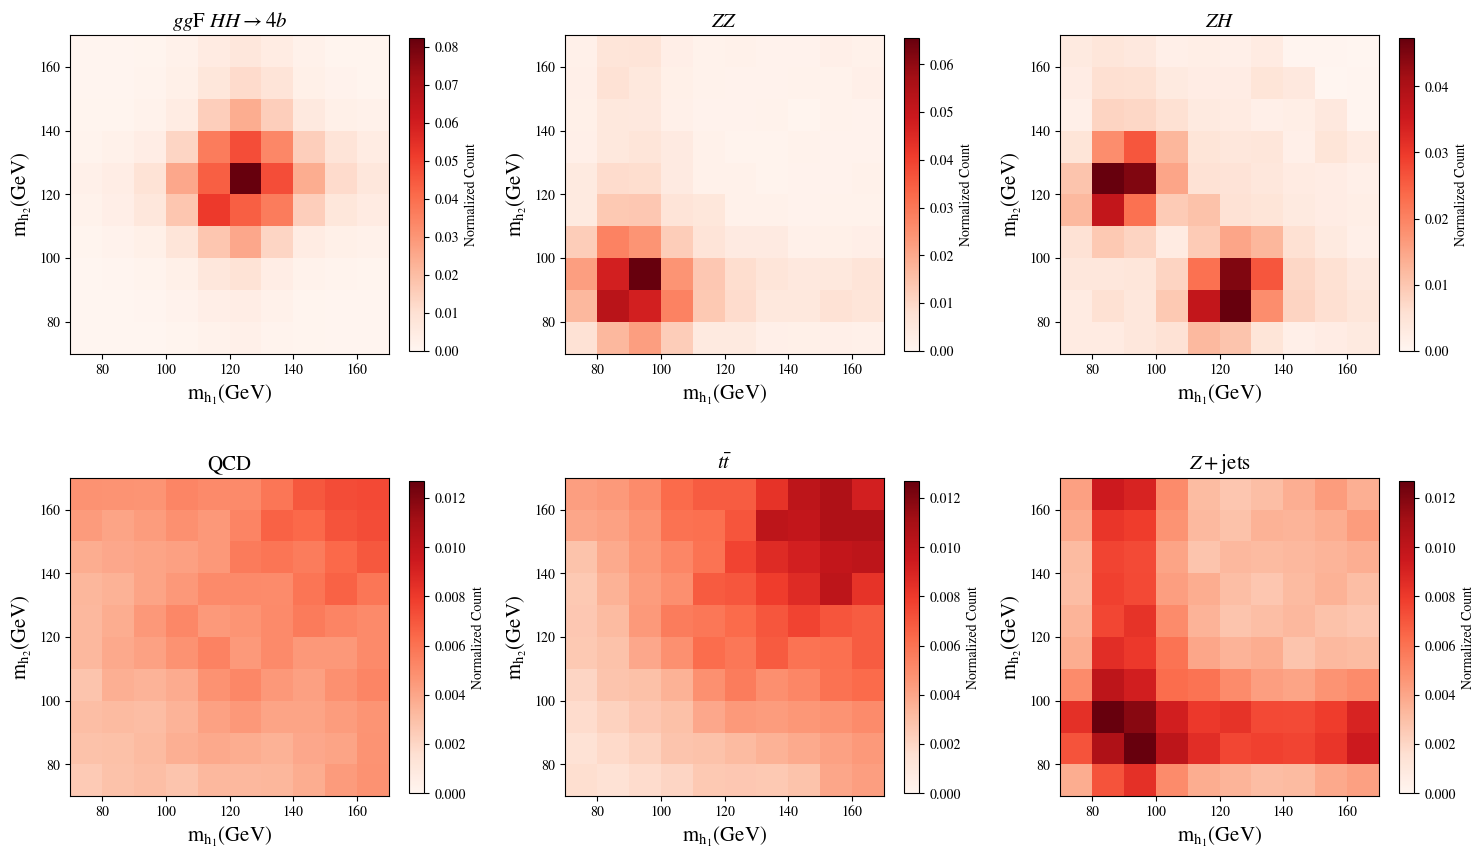

In [3]:
# base_dir = '/publicfs/cms/user/tyyang99/weaver_predict/hh4b_resolved_newsp4_allparts_nosel_139clswtopwboson.noweights.ddp4-bs384-lr1p5e-3'
base_dir = '/publicfs/cms/user/tyyang99/weaver_predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3'

lumi_scale = 4.5 # 450 fb^-1

# Weight dictionary - pre-calculated
weight_dict = { # expected_total_nevents / produced_nevents
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / (17600 * 50e5), # calculate from inclusive pythia events
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5), # calculate from pre-MLM-filtered MG nevents

    # the following are calculated from inclusive nevents
    "TTbar": lumi_scale * 83175900 / 40305472, 
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

# cut_value = 0.999796
cut_value = 0.9
# cut_value = 0.9999
cut_name = f"cut{str(cut_value).replace('.','p')}"

folder_pattern = f"{base_dir}/*"
background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
# process_list = ['ggHH'] + background_processes
process_list = ['ggHH'] + ['QCD', 'TTbar', 'ZH', 'ZJetsToQQ', 'ZZ']

H_dict = {}
bins = np.arange(40, 210, 10)

matching_files = glob.glob(folder_pattern)
for proc_name in process_list:

    f_id = 0

    fit_results_list = []
    
    all_x_means = []
    all_y_means = []
    all_weights = []

    weight = weight_dict[proc_name]

    for ifile in matching_files:
        if (f"{proc_name}_" not in ifile) or ('herwig' in ifile) or ('vincia' in ifile):
            continue
        name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
        print(f_id, name)
        f_id += 1
            
        dcbfit_file = f"/publicfs/cms/user/tyyang99/forIHEP/dcb_fit_results_backup/{base_dir.split('/')[-1]}/pred_{name}/pred_{name}_combined_fit_results.npz"
        try:

            pred_file = f"{base_dir}/pred_{name}.root"
            pred_data_tmp = uproot.lazy(pred_file)
            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
            
            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
            for j in range(136):
                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
            pred_data['score_hhvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
            pred_data['score_hhvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])

            # # cut_value = 0.9999
            print(f"rate for hhvsboth > {cut_value}:", np.sum((pred_data['score_hhvsboth'] > cut_value))/len(pred_data))            
            selection_mask = (pred_data['score_hhvsboth'] > cut_value)
            # print(f"rate for hhvsqcd > {cut_value}:", np.sum((pred_data['score_hhvsqcd'] > cut_value))/len(pred_data))            
            # selection_mask = (pred_data['score_hhvsqcd'] > cut_value)
            
            fit_results = np.load(dcbfit_file)

            fit_success = fit_results['fit_success']
            p1_x_mean = fit_results['p1_x_mean']
            p1_y_mean = fit_results['p1_y_mean']
            p1_amp = fit_results['p1_amp']
            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)

            assert len(pred_data)==len(p1_x_mean)

            fit_cut = (
                (fit_success==1) & (np.abs(p1_amp/p2_amp)>0) & selection_mask
            )
            
            p1_x_mean = p1_x_mean[fit_cut]
            p1_y_mean = p1_y_mean[fit_cut]
            # p2_x_mean = p2_x_mean[fit_cut]
            # p2_y_mean = p2_y_mean[fit_cut]

            print(len(p1_x_mean))
            # print(np.sum(p1_x_mean<=p1_y_mean))
            
            if len(p1_x_mean) > 0:
                event_weights = np.ones_like(p1_x_mean) * (weight)

                p1_cut = (p1_x_mean >= 40) & (p1_x_mean <= 200) & (p1_y_mean >= 40) & (p1_y_mean <= 200)
                
                # peak_posi_x = np.where(p1_cut, p1_x_mean, p2_x_mean)
                # peak_posi_y = np.where(p1_cut, p1_y_mean, p2_y_mean)
                
                all_x_means.append(p1_x_mean)
                all_y_means.append(p1_y_mean)
                # all_x_means.append(peak_posi_x)
                # all_y_means.append(peak_posi_y)
                all_weights.append(event_weights)
                fit_results_list.append(fit_results)
            
        except Exception as e:
            continue

    if all_x_means:
        x_means = np.concatenate(all_x_means)
        y_means = np.concatenate(all_y_means)
        weights = np.concatenate(all_weights)
        
        if proc_name in process_list:

            delta_threshold = 15.0  
            prob_scale = 0.4       
            disturb_strength = 8.0 
            min_val, max_val = 40.0, 200.0
            
            x_means_new = np.copy(x_means)
            y_means_new = np.copy(y_means)
            
            for i in range(len(x_means)):
                x = x_means[i]
                y = y_means[i]
                d = abs(x - y)
                
                if d < delta_threshold:
                    sigma = delta_threshold / 2.0
                    p = prob_scale * np.exp(-d / sigma)
                    
                    if random.random() < p:
                        if x > y:
                            direction = (1, -1)  
                        else:
                            direction = (-1, 1)  
                        
                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                        
                        new_x = x + direction[0] * delta
                        new_y = y + direction[1] * delta
                        
                        new_x = np.clip(new_x, min_val, max_val)
                        new_y = np.clip(new_y, min_val, max_val)
                        
                        if abs(new_x - new_y) > d:
                            x_means_new[i] = new_x
                            y_means_new[i] = new_y
            
            x_means = x_means_new
            y_means = y_means_new
            
        H, xedges, yedges = np.histogram2d(
            x_means, y_means, 
            bins=[bins, bins], 
            weights=weights
        )
        
        H = (H + H.T) / 2
        H_dict[proc_name] = H
        print(f"{proc_name}: 总和 = {np.sum(H)}")
        print(np.sum(H,axis=1))
        print(np.sum(weights))
    else:
        H = np.zeros((len(bins)-1, len(bins)-1))
        H_dict[proc_name] = H

make_plot(H_dict, '2d', cut_name)

